# Generate input files for MOM6
Each cell corresponds to a different component of the initialization  
This includes grid, sponge, TS, wind forcing, buoyancy forcing  
Save netcdf files to the INPUT file of the configuration, with a simulation-specific name

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

rootdir = '/Users/hemantkhatri/Documents/Acads/GFDL/Github_scripts/GFDL_Graeme/channel'
config = 'Idealised_SO'
simulation = '4th-deg'

# Grid
Define the parameters of the grid  
Output the vertical and horizontal coordinate, and a 2D mesh of the horizontal coordinates  

In [4]:
# ___ HORIZONTAL GRID ___#
# Specify geometry of horizontal grid and it MUST BE CONSISTENT WITH THE MODEL GRID
# Latitude and longitude
SOUTHLAT, LENLAT = (-70.0, 50.0)
WESTLON, LENLON = (0.0, 80.0)

MAXIMUM_DEPTH, MINIMUM_DEPTH = (4000., 0.)

# Number of grid cells
NI, NJ = (int(LENLON*4), int(LENLAT*4))

# Grid point positions (tracer point)
X = np.linspace(WESTLON,WESTLON+LENLON,NI+1)
X1d = (X[1:] + X[:-1]) / 2
Y = np.linspace(SOUTHLAT,SOUTHLAT+LENLAT,NJ+1)
Y1d = (Y[1:] + Y[:-1]) / 2
X,Y = np.meshgrid(X1d,Y1d)

# Define lat and lon dimensions set to zero at the midpoint
X0 = xr.DataArray(np.linspace(-NI/2,NI/2,NI),coords=[X1d],dims='lon')
Y0 = xr.DataArray(np.linspace(-NJ/2,NJ/2,NJ),coords=[Y1d],dims='lat')
# Define xarray data array with dimensions of horizontal grid
# (for broadcasting dimensions of other variables later in the notebook)
hgrid = xr.DataArray(np.ones([NI,NJ]),coords=[X1d,Y1d],dims=['lon','lat'])


# Defile Topography
Includes a shelf ridge on the southern boundary and elongated ridge structure in the middle of the domain smoothly decaying to zero at some points.

In [37]:
def create_shelf(H, Hs, Y1, Ys, Ws):
    # H = max depth, Hs = shelf depth, Y1 = lat, Ys = shelf latitude, Ws = shelf width
    depth_shelf = 0.5*(H - Hs)*(1 - np.tanh((Y1 - Ys)/Ws))
    
    return depth_shelf

def create_ridge_bump(Hs, X1, Xs, Y1, Ys, W1s, W2s):
    # H = max depth, Hs = ridge depth, X1 = lon, Y1 = lat, Xs, Ys = shelf lan and lat, W1s, W2s = ridge length and width
    bump_X = np.exp(-((X1 - Xs)/W1s)**2)
    bump_Y = np.exp(-((Y1 - Ys)/W2s)**2)
    depth_bump = Hs*bump_X*bump_Y
    
    return depth_bump
    
depth = MAXIMUM_DEPTH*hgrid

min_shelf_depth, shelf_lat, shelf_width = (500., -60., 3.0)
d_shelf = create_shelf(MAXIMUM_DEPTH, min_shelf_depth, hgrid.lat, shelf_lat, shelf_width)

max_bump_height, bump_lon, bump_lat = (3000., 20., -40)
bump_width_X, bump_width_Y = (10., 10.)

d_bump = create_ridge_bump(max_bump_height, hgrid.lon, bump_lon, hgrid.lat, bump_lat, bump_width_X, bump_width_Y)

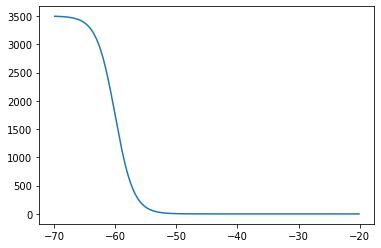

In [42]:
#hgrid.lat
plt.plot(hgrid.lat, d_shelf)

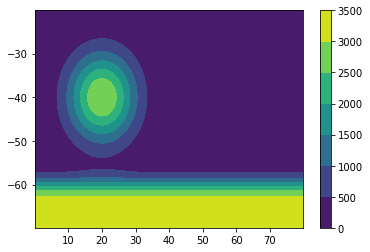

In [45]:
plt.contourf(hgrid.lon, hgrid.lat, (d_bump + d_shelf).transpose())
plt.colorbar()